In [ ]:
#Tek başınayken aykırı olmayacak değerler,başka bir değerle birlikteyken aykırılık yaratıyor olabilir.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
data = sns.load_dataset("diamonds")
data = data.select_dtypes(include=["float64", "int64"])
data = data.dropna()
data.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
  quantile1 = dataframe[col_name].quantile(q1)
  quantile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quantile3 - quantile1
  up_limit = quantile3 + 1.5 * interquantile_range
  low_limit = quantile1 - 1.5 * interquantile_range
  return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
for col in data.columns:
  print(col, check_outlier(data, col))

carat True
depth True
table True
price True
x True
y True
z True


In [ ]:
low, up = outlier_thresholds(data, "carat")
data[(data["carat"] < low) | (data["carat"] > up)].shape

(1889, 7)

In [ ]:
low, up = outlier_thresholds(data, "depth")
data[(data["depth"] < low) | (data["depth"] > up)].shape

(2545, 7)

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(data)

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
df_scores = clf.negative_outlier_factor_
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

In [ ]:
np.sort(df_scores)[0:5] #En kötü 5 score

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

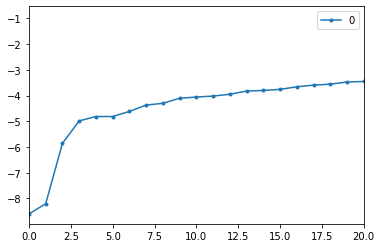

In [ ]:
#Her bir nokta eşik değerleri temsil ediyor. Eğim değişikliğinin en bariz olduğu noktayı eşik değer olarak belirleyebiliriz.
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0,20], style=".-")
plt.show()

In [ ]:
#Bu değeri threshold olarak belirleyebiliriz.
th = np.sort(df_scores)[3]

In [ ]:
#Eşik değerimiz:
th

-4.984151747711709

In [ ]:
data[df_scores < th].shape

(3, 7)

In [ ]:
data[df_scores < th]

,carat,depth,table,price,x,y,z
41918,1.03,78.2,54.0,1262,5.72,5.59,4.42
48410,0.51,61.8,54.7,1970,5.12,5.15,31.80
49189,0.51,61.8,55.0,2075,5.15,31.80,5.12


In [ ]:
#Değişkenlere tek tek baktığımızda aykırı değerleri daha yüksek .ıkıyordu. Oysaki şuan 3 tane :)
#Çünkü çok değişkenli etkiye bakıyoruz.
#Peki bu değerler neden aykırı ? Yukarıdaki outlier değerleriyle buradaki grafiği karşılaştırdığımızda th
data.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.0,0.797940,0.474011,0.2,0.24,0.30,0.70,1.04,1.51,2.18,5.01
depth,53940.0,61.749405,1.432621,43.0,57.90,59.30,61.80,62.50,63.30,65.60,79.00
table,53940.0,57.457184,2.234491,43.0,53.00,54.00,57.00,59.00,60.00,64.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,429.00,544.00,2401.00,5324.25,9821.00,17378.22,18823.00
x,53940.0,5.731157,1.121761,0.0,4.02,4.29,5.70,6.54,7.31,8.36,10.74
y,53940.0,5.734526,1.142135,0.0,4.04,4.30,5.71,6.54,7.30,8.34,58.90
z,53940.0,3.538734,0.705699,0.0,2.48,2.65,3.53,4.04,4.52,5.15,31.80


In [ ]:
data[df_scores<th].index


Int64Index([41918, 48410, 49189], dtype='int64')

In [ ]:
data[df_scores<th].drop(axis=0, labels=data[df_scores<th].index)

,carat,depth,table,price,x,y,z


Baskılama yöntemi de kullanabiliriz ancak kimle baskılayacağımızı bilmiyoruz.
Gözlem sayısı fazlasyda bu veriyi bozacağımız anlamına gelir.
Ağaç yöntemleri kullanıyorsak aykırı yöntemlere dokunmuyoruz, dokunacaksak da çok ucundan thrashlıyoruz.
%99 luk 95lik kısımlarına dokunmalıyız.
Doğrusal yöntemler kullanıyorsak doldurmak yerine az sayıdaysa silmek daha sağlıklı bir çözümdür.